Se tratará de realizar la aproximación usando QVR y Regressor que proporciona la biblioteca de Qiskit para problemas de regresión

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
print(df.head())
print(df.tail())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
            #Passengers
Month                  
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432


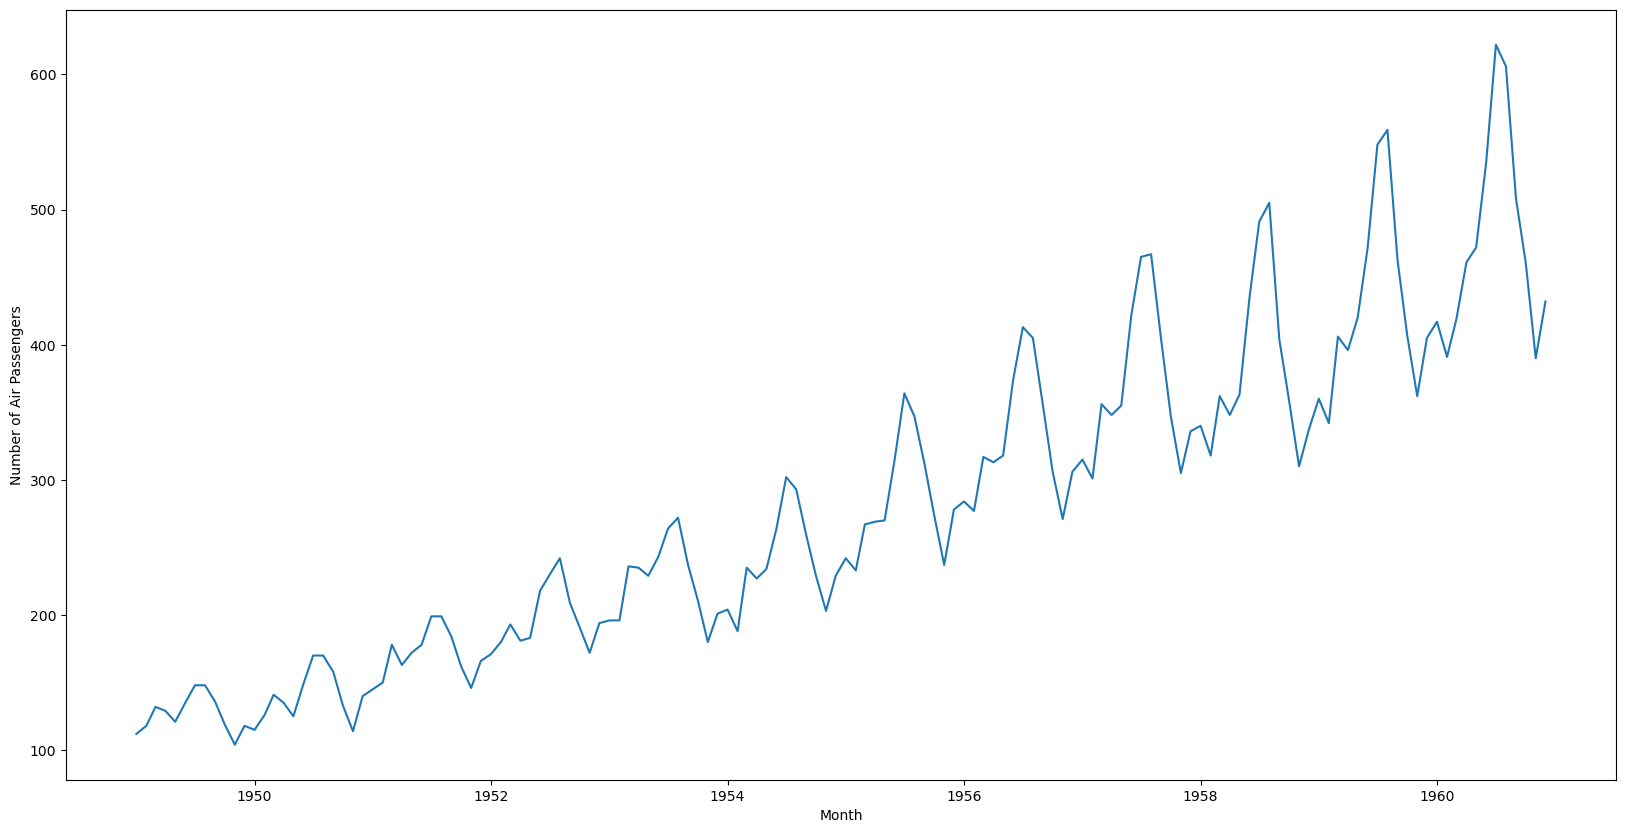

In [4]:
plt.figure(figsize=(20,10))
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")
plt.plot(df)
plt.show()

In [5]:
rolmean=df.rolling(window=12).mean()
rolstd=df.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01    13.720147
1950-01-01    13.453342
1950-02-01    13.166475
1950-03-01    13.686977


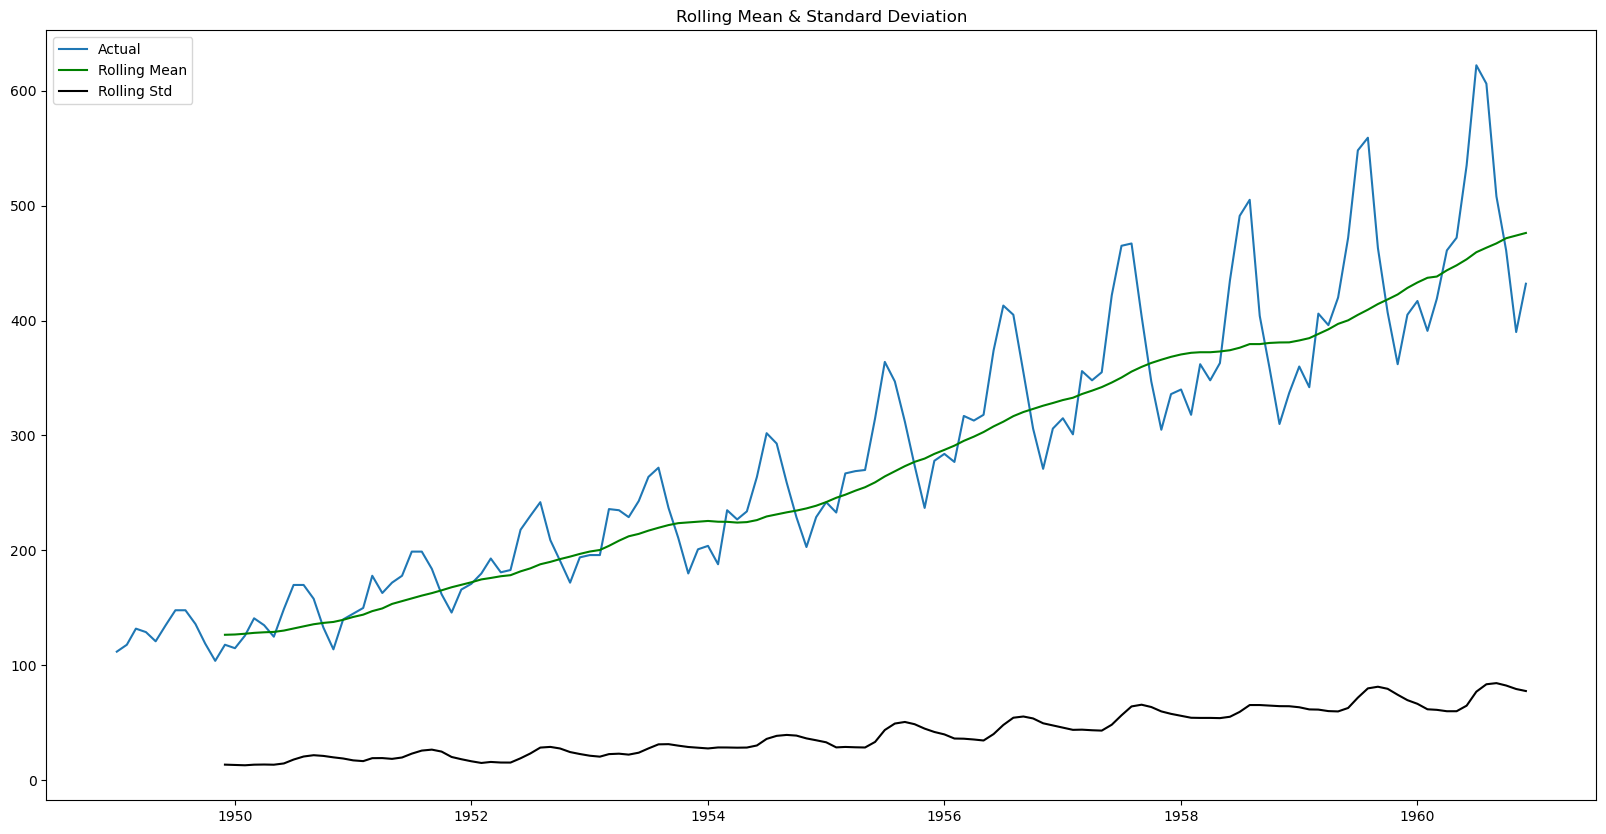

In [6]:
plt.figure(figsize=(20,10))
actual=plt.plot(df, label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Vemos que tanto la media como la desviación típica tienen una tendencia creciente.

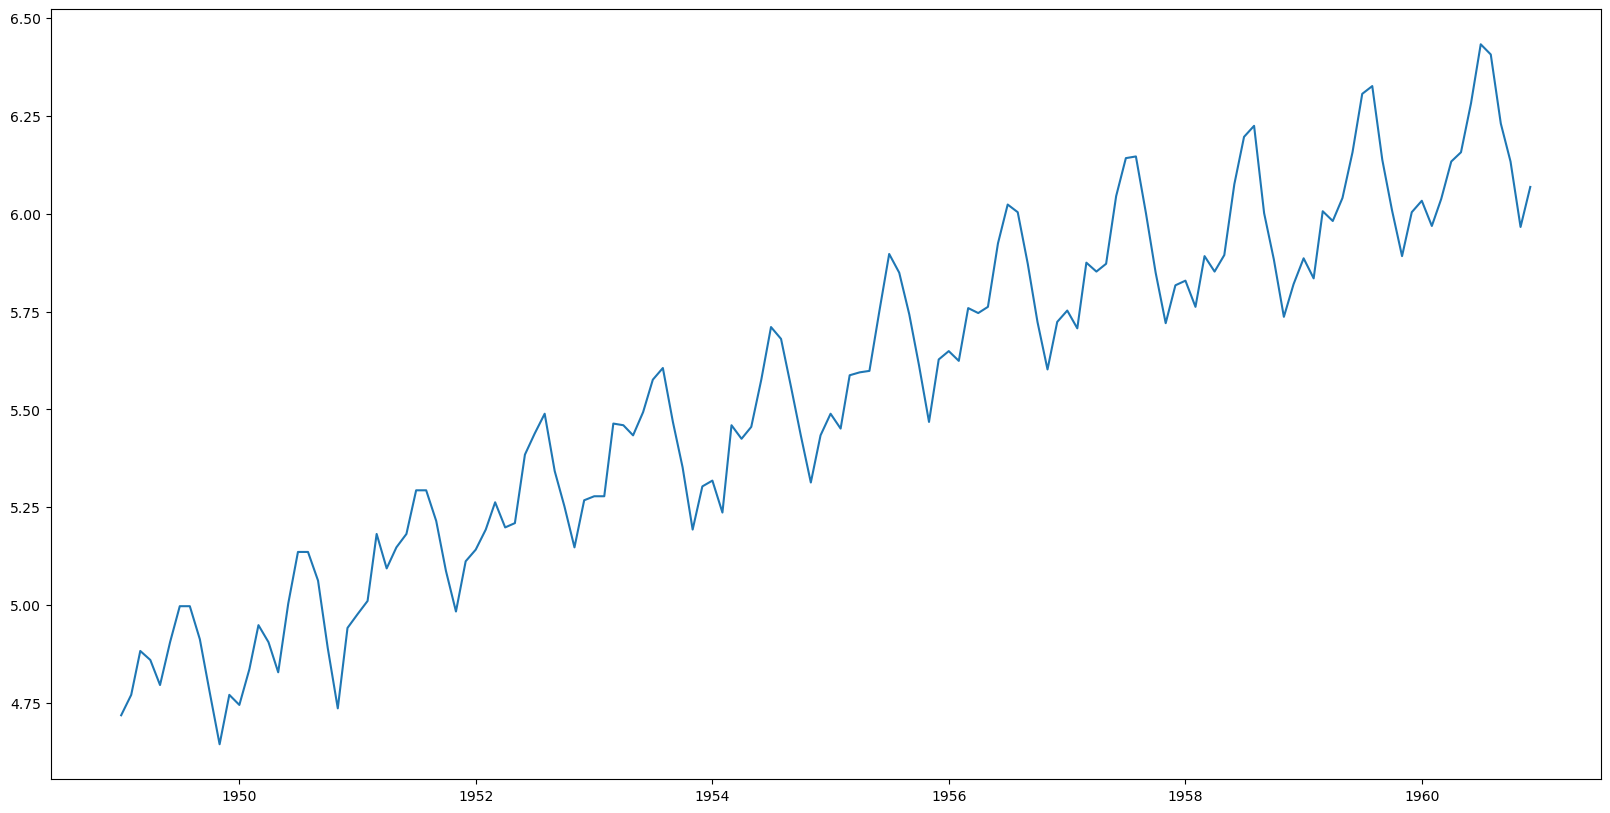

In [7]:
df_log=np.log(df)
plt.figure(figsize=(20,10))
plt.plot(df_log)
plt.show()

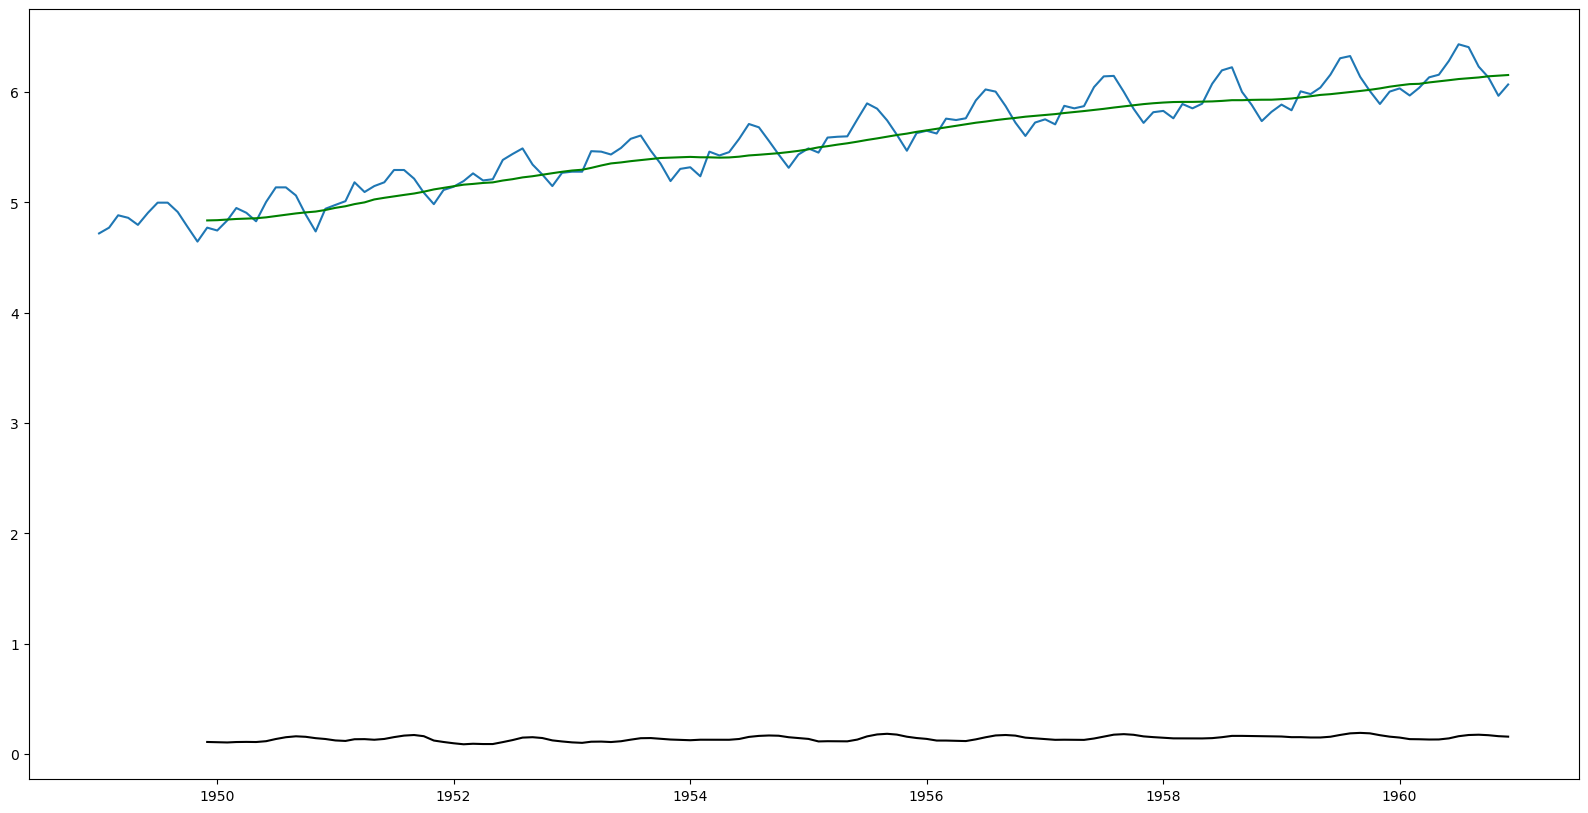

In [8]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=12).mean()
MStd=df_log.rolling(window=12).std()
plt.plot(df_log, label='Transformacion logaritmica')
plt.plot(MAvg, color='green', label='Rolling Mean') 
plt.plot(MStd, color='black', label='Rolling Std')

Tras aplicar la transformación logarítmica obtenemos desviación típica casi constante y media creciente

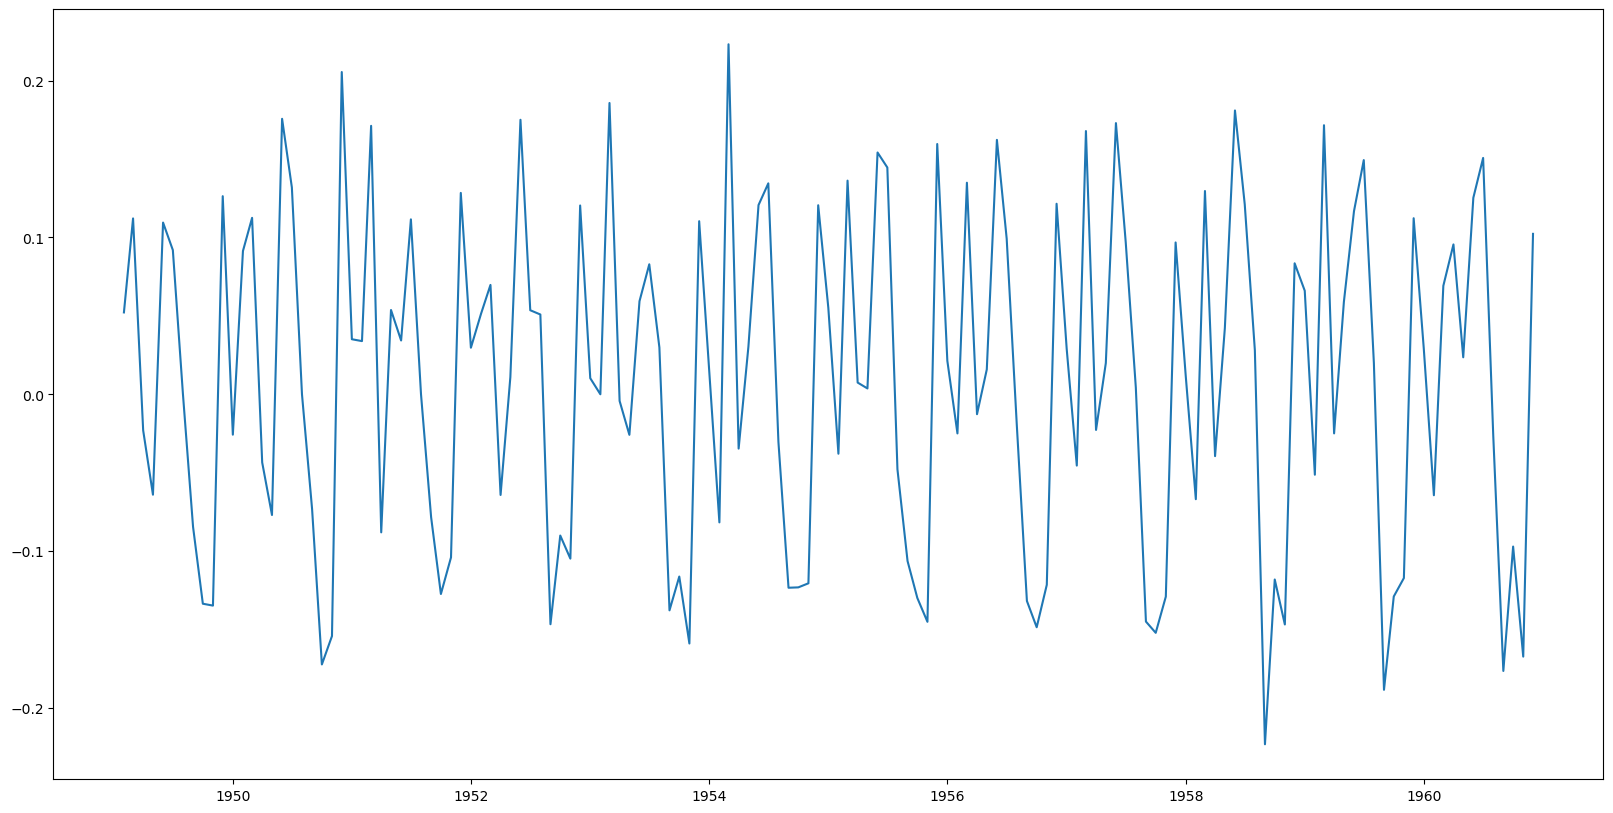

In [9]:
plt.figure(figsize=(20,10))
data_shift=df_log-df_log.shift()
plt.plot(data_shift)
plt.show()

In [10]:
data_shift

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


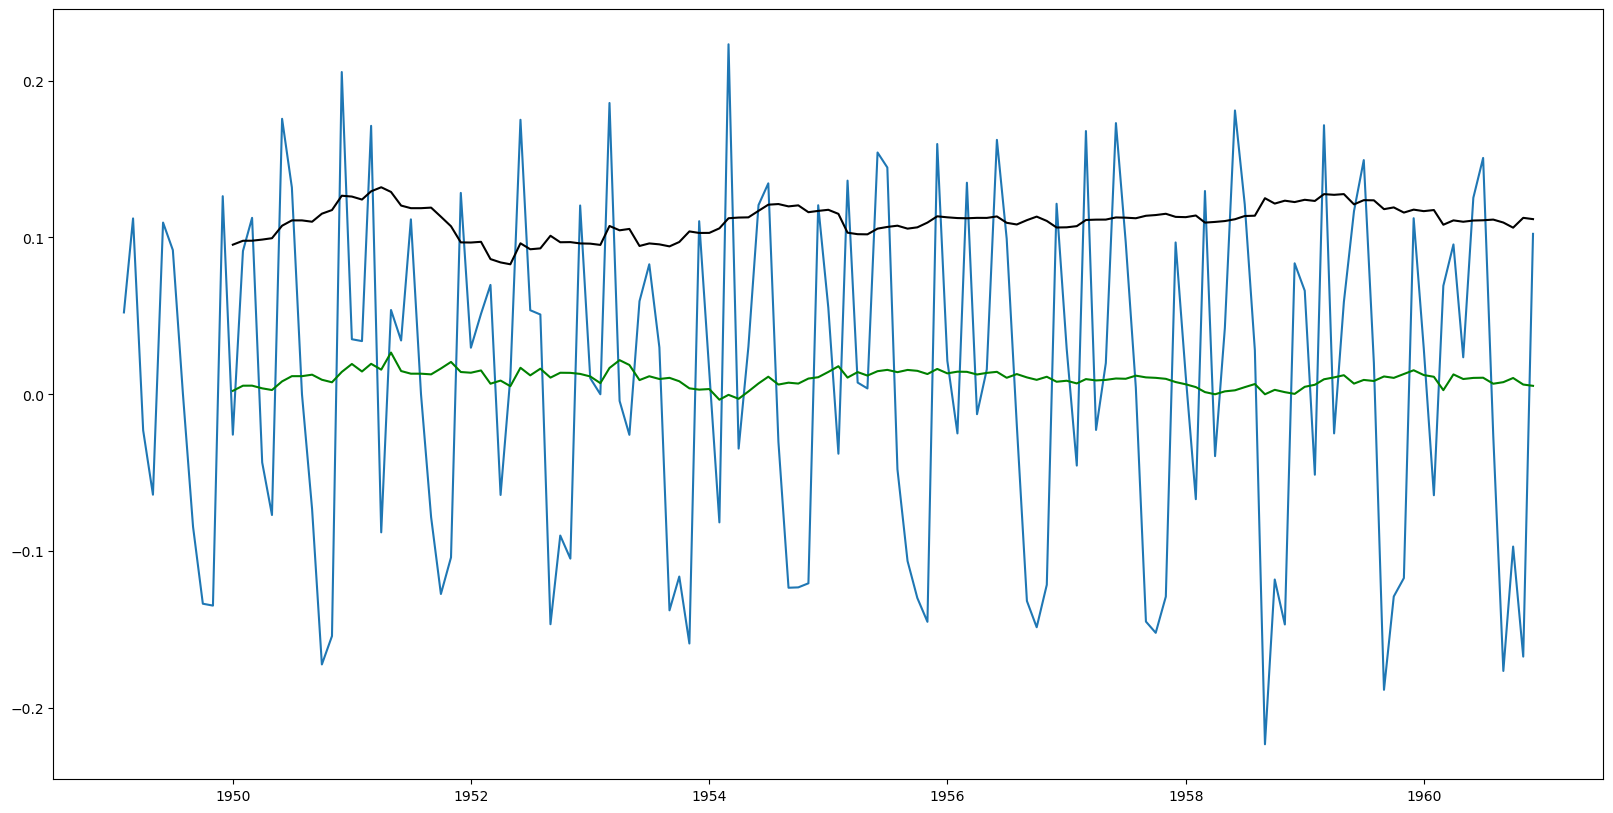

In [11]:
plt.figure(figsize=(20,10))
MAvg=data_shift.rolling(window=12).mean()
MStd=data_shift.rolling(window=12).std()
plt.plot(data_shift, label='Transformacion logaritmica diferenciada')
plt.plot(MAvg, color='green', label='Rolling Mean') 
plt.plot(MStd, color='black', label='Rolling Std')
plt.show()

La desviación típica y la media son casi constantes

Finalmente, preparemos los datos para ser entrenados, solo quiero los datos de vuelo. Por la diferenciación el primer dato no tiene valor, así que lo descartamos.

In [12]:
data_shift = data_shift.dropna()
data_shift

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [13]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [14]:
tiempo = data_shift.drop(['#Passengers'], axis=1)
tiempo_train = tiempo.head(int(pasajeros.shape[0]*0.8))
tiempo_test = tiempo.tail(pasajeros.shape[0] - int(pasajeros.shape[0]*0.8))

In [15]:
window = 4;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

index = np.arange(0,tam_train)
np.random.seed(444422)
np.random.shuffle(index)

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_train = objetivo_train[index]
conjunto_train = conjunto_train[index]

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

Normalicemos

In [16]:
objetivo_train_nor = objetivo_train/np.linalg.norm(objetivo_train)
conjunto_train_nor = conjunto_train/np.linalg.norm(conjunto_train)

objetivo_test_nor = objetivo_test/np.linalg.norm(objetivo_test)
conjunto_test_nor = conjunto_test/np.linalg.norm(conjunto_test)

In [17]:
def modelRegresor_CodificacionAngular(n_qubits=1):
    n_capas = 50
    inputs = ParameterVector("inputs",n_qubits)
    params = ParameterVector("weights", n_capas*n_qubits)
    qc = QuantumCircuit(n_qubits)
    
    feature_map = ZFeatureMap(n_qubits)
    
    ansatz = QuantumCircuit(n_qubits, name="vf")
    for j in range(0,int(n_capas/2)):
        for i in range(0,n_qubits):
            ansatz.ry(params[i+j*n_qubits], i)
            
        for i in range(0,n_qubits-1):
            ansatz.cz(0,i+1)
        
        for i in range(0,n_qubits):
            ansatz.ry(params[i+(j+1)*n_qubits], i)
        if(j != n_capas-1):
            for i in range(0,n_qubits-1):
                ansatz.cz(n_qubits-1,n_qubits-2-i)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    model = EstimatorQNN(
        circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
    )
    
    
    return inputs, params, model, feature_map, ansatz

In [18]:
inputs, params, modelo, _, _ = modelRegresor_CodificacionAngular(window)

In [19]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    

In [20]:
regressor = NeuralNetworkRegressor(
    neural_network=modelo,
    loss="squared_error",
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph
)

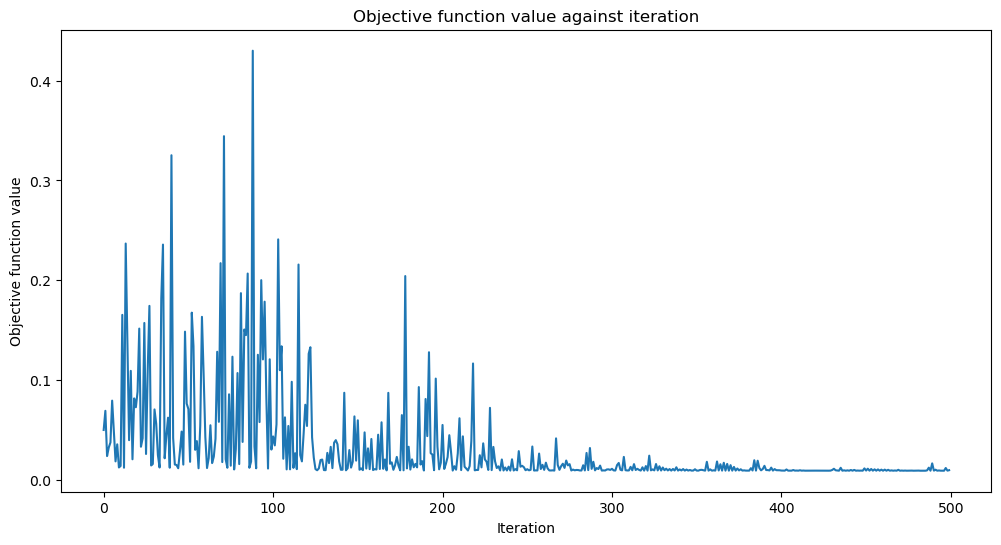

In [21]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)

In [22]:
regressor.score(conjunto_train, objetivo_train)

0.1851374122493562

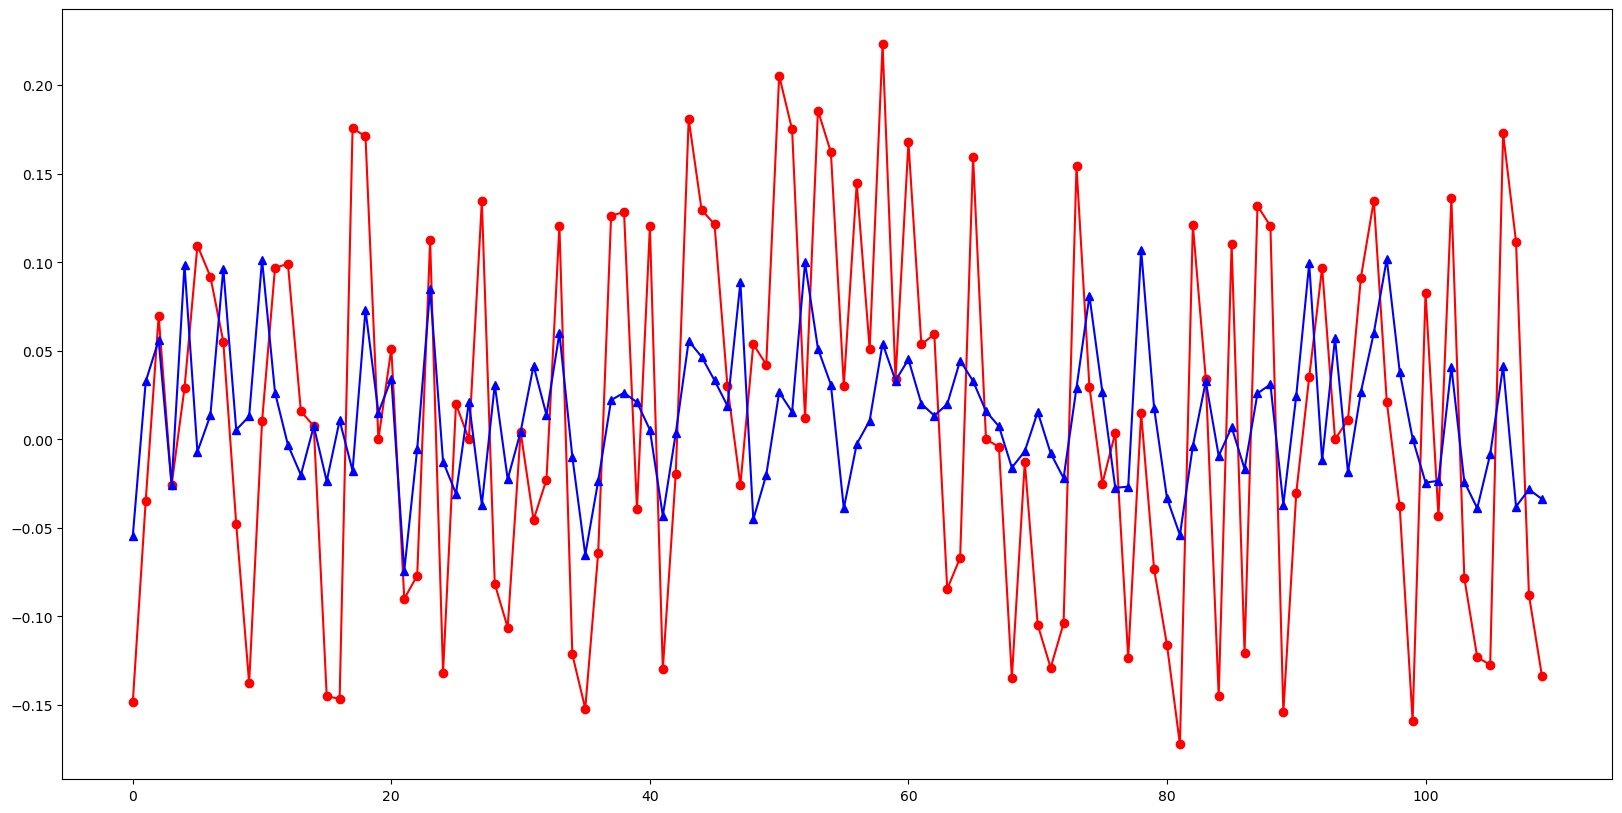

In [23]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()

In [24]:
np.sum( (objetivo_train - y_)**2)/len(objetivo_train)

1.3748305880540763

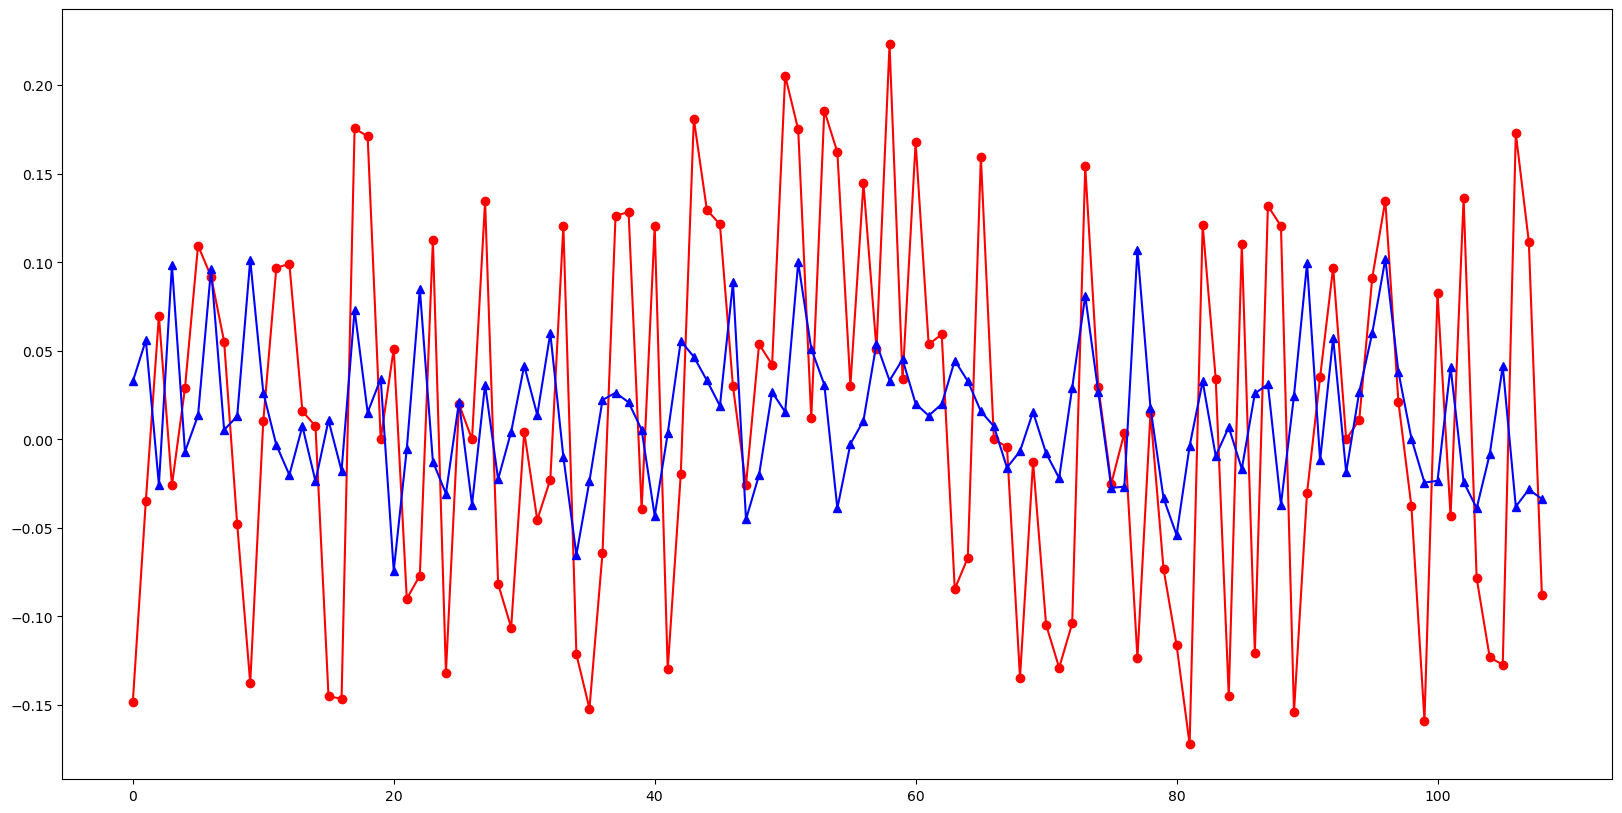

1.3485891815000497

In [25]:
plt.figure(figsize=(20,10))
plt.plot(espacio[:conjunto_train.shape[0]-1] ,objetivo_train[:conjunto_train.shape[0]-1], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:conjunto_train.shape[0]-1],(y_[1:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_train[:conjunto_train.shape[0]-1] - y_[1:])**2)/(len(objetivo_train)-1)

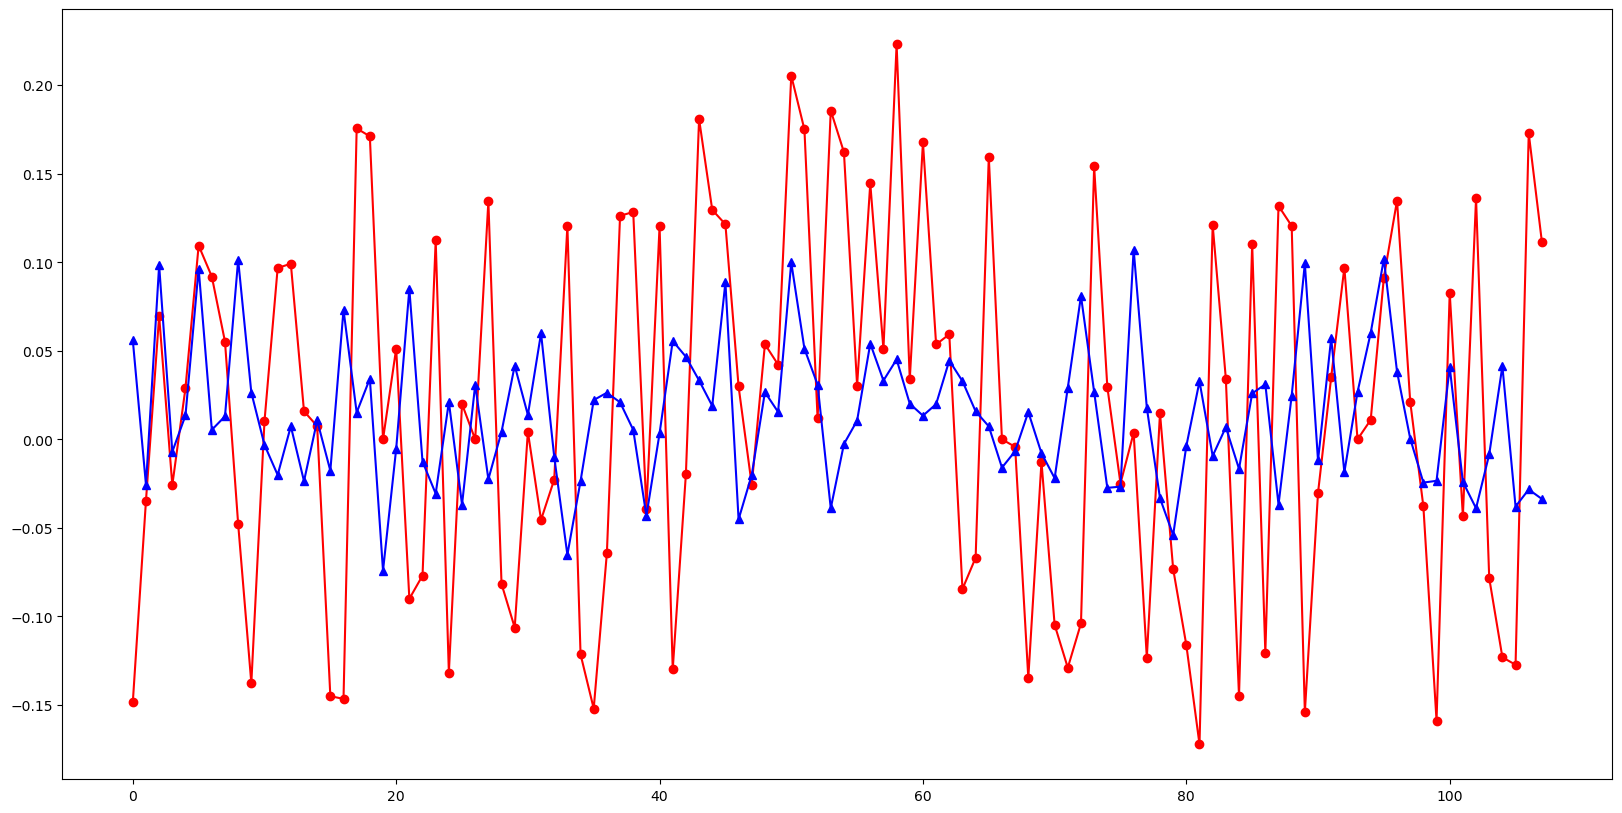

1.3379003728208123

In [26]:
plt.figure(figsize=(20,10))
plt.plot(espacio[:conjunto_train.shape[0]-2] ,objetivo_train[:conjunto_train.shape[0]-2], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:conjunto_train.shape[0]-2],(y_[2:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_train[:conjunto_train.shape[0]-2] - y_[2:])**2)/(len(objetivo_train)-2)

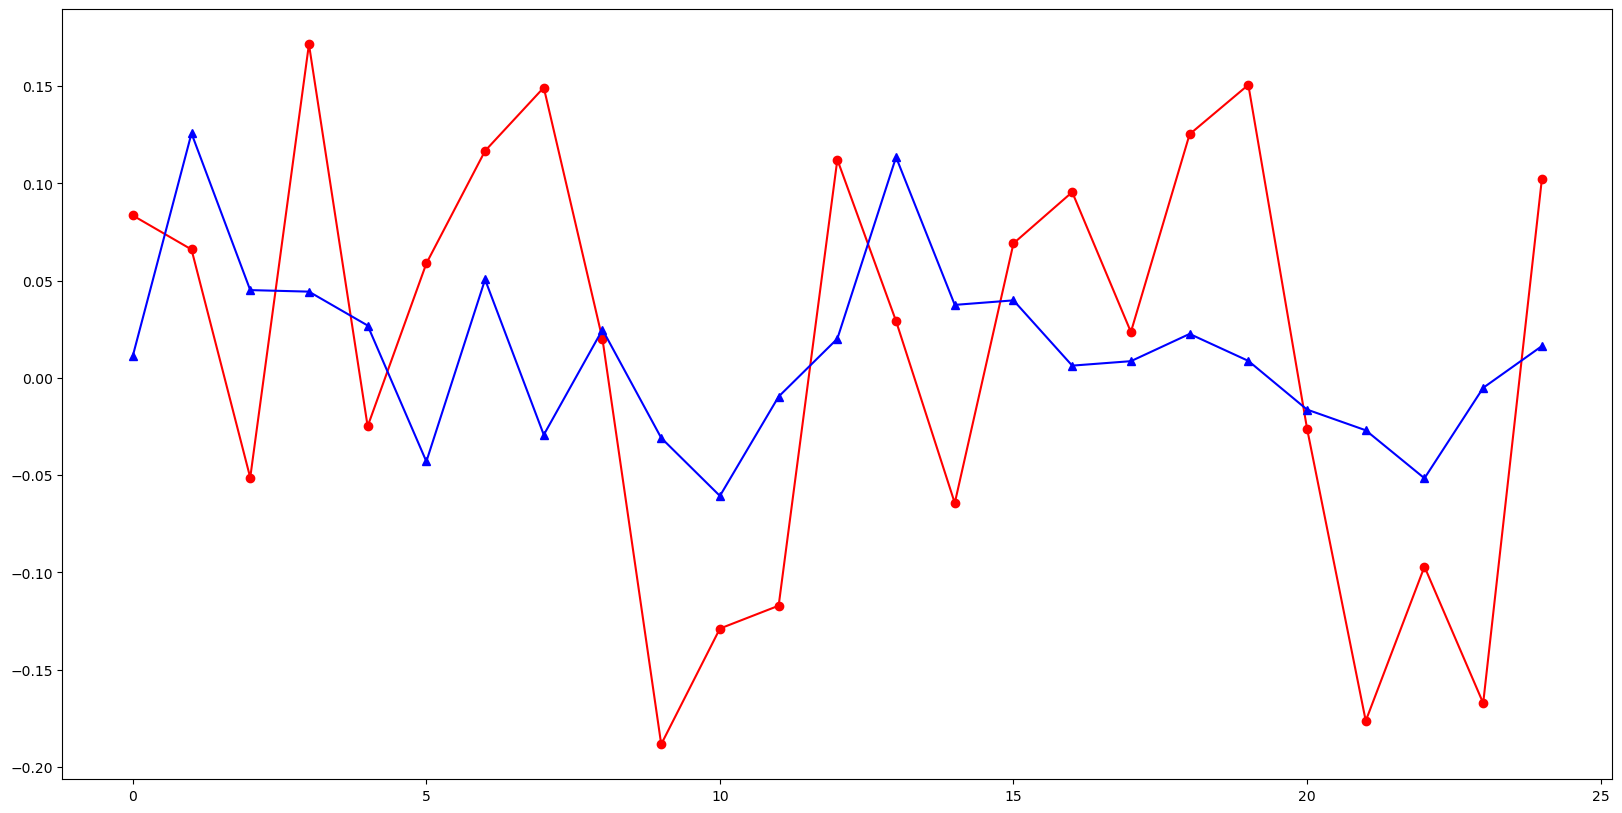

0.34323665104972206

In [27]:
plt.figure(figsize=(20,10))
espacio = np.arange(0,conjunto_test.shape[0])
y_ = regressor.predict(conjunto_test)
plt.plot(espacio ,objetivo_test, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,(y_) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test - y_)**2)/len(objetivo_test)

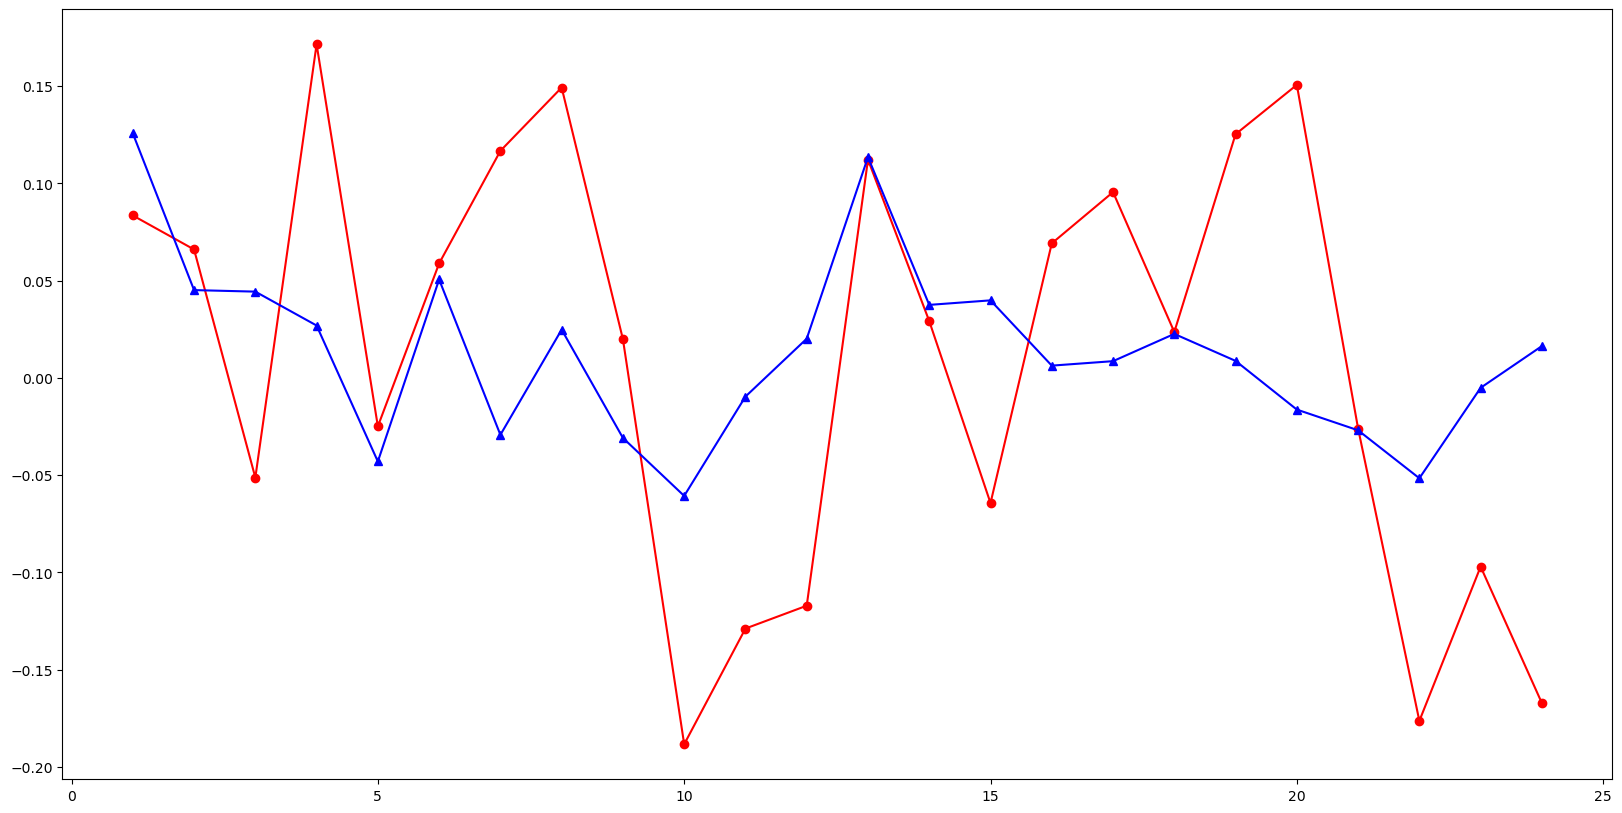

0.34522803282196524

In [28]:
plt.figure(figsize=(20,10))
plt.plot(espacio[1:] ,objetivo_test[:len(espacio)-1], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[1:],(y_[1:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test[:len(espacio-1)] - y_[1:])**2)/(len(objetivo_test)-1)

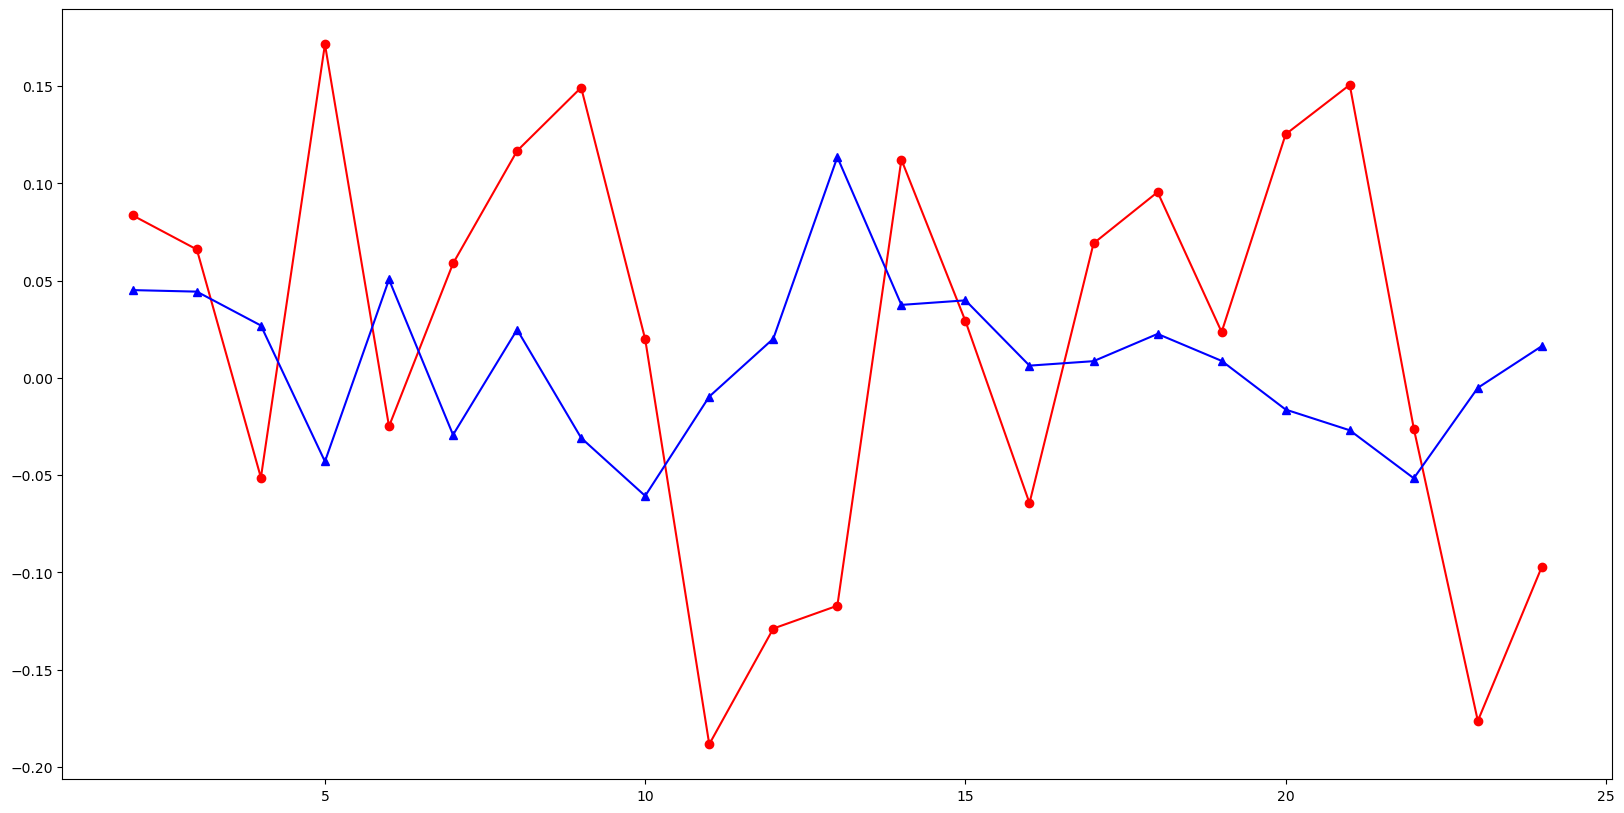

0.3336476473384237

In [29]:
plt.figure(figsize=(20,10))
plt.plot(espacio[2:] ,objetivo_test[:len(espacio)-2], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[2:],(y_[2:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test[:len(espacio-2)] - y_[2:])**2)/(len(objetivo_test)-2)

## Variacional

In [30]:
inputs2, params2, modelo2, f1, f2 = modelRegresor_CodificacionAngular(window)

In [31]:
vqr = VQR(
    feature_map=f1,
    ansatz=f2,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph,
)

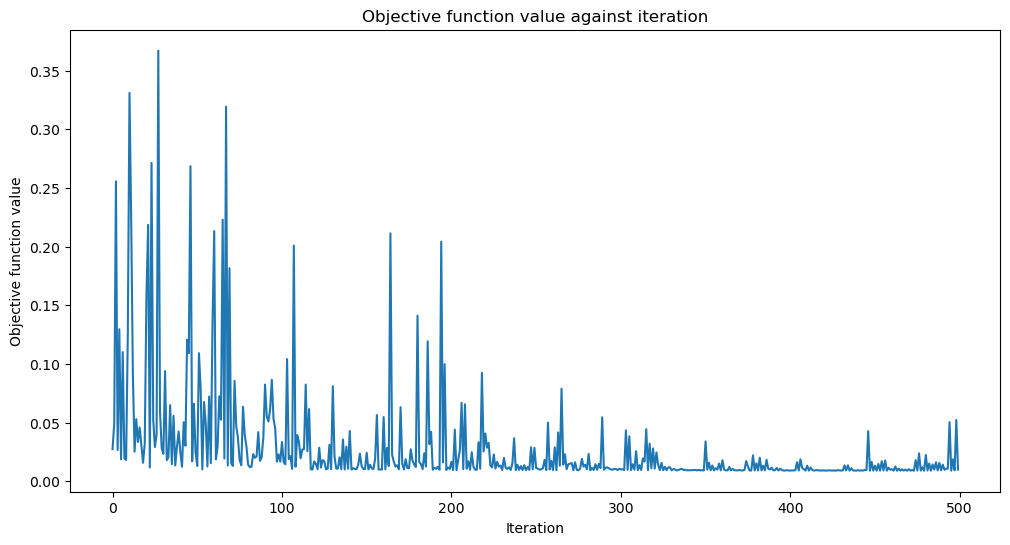

0.1873695778919353

In [32]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(conjunto_train, objetivo_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(conjunto_train, objetivo_train)

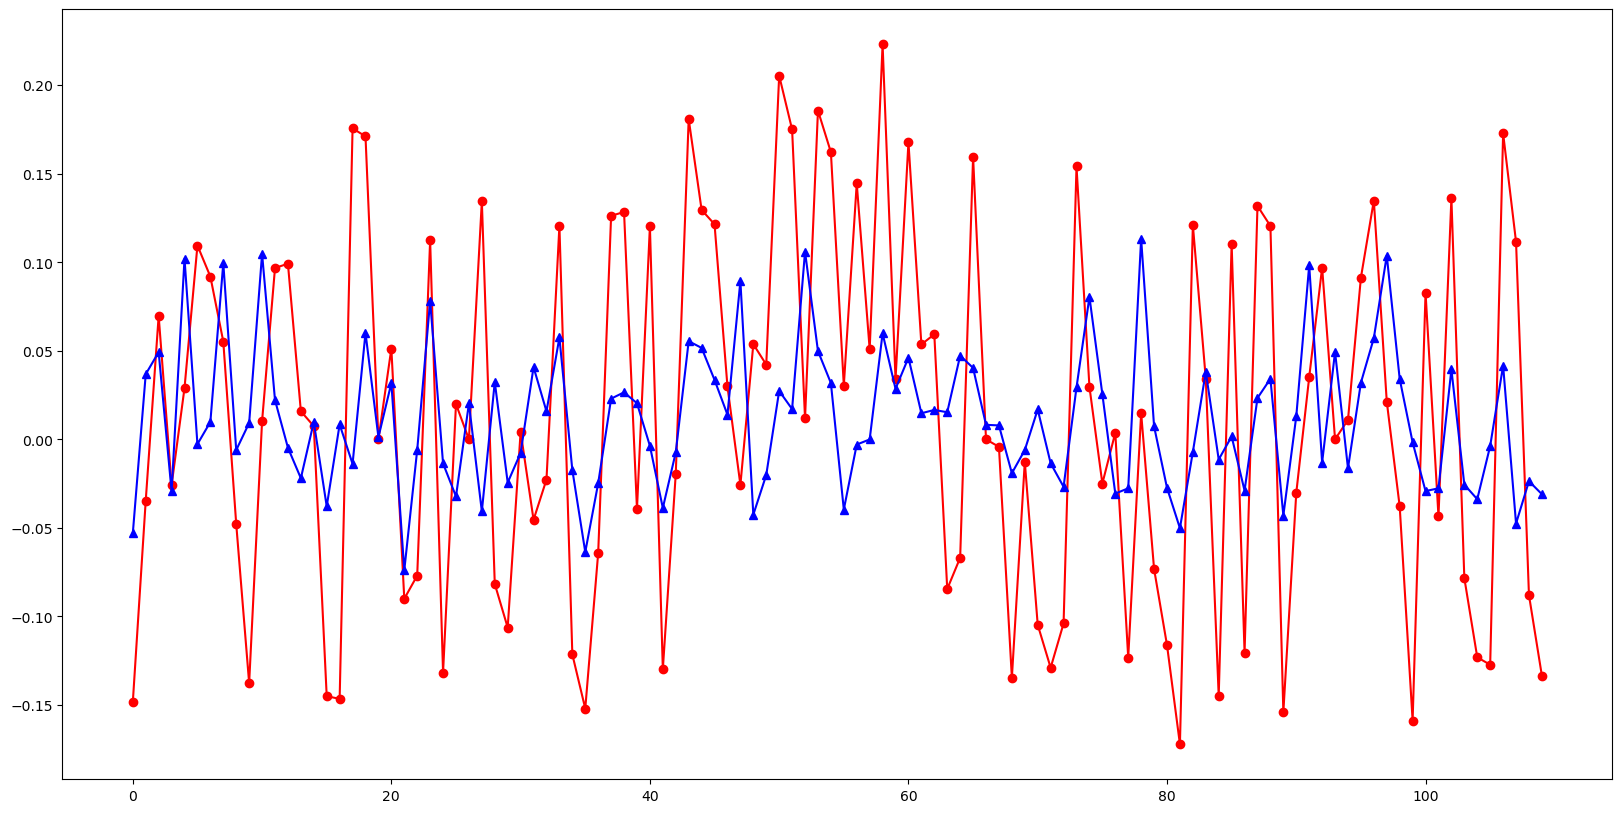

1.3819004277494005

In [33]:
plt.figure(figsize=(20,10))
espacio = np.arange(0,conjunto_train.shape[0])
y_ = vqr.predict(conjunto_train)
plt.plot(espacio[:] ,objetivo_train[:], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:],(y_[:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_train[:] - y_[:])**2)/(len(objetivo_train))

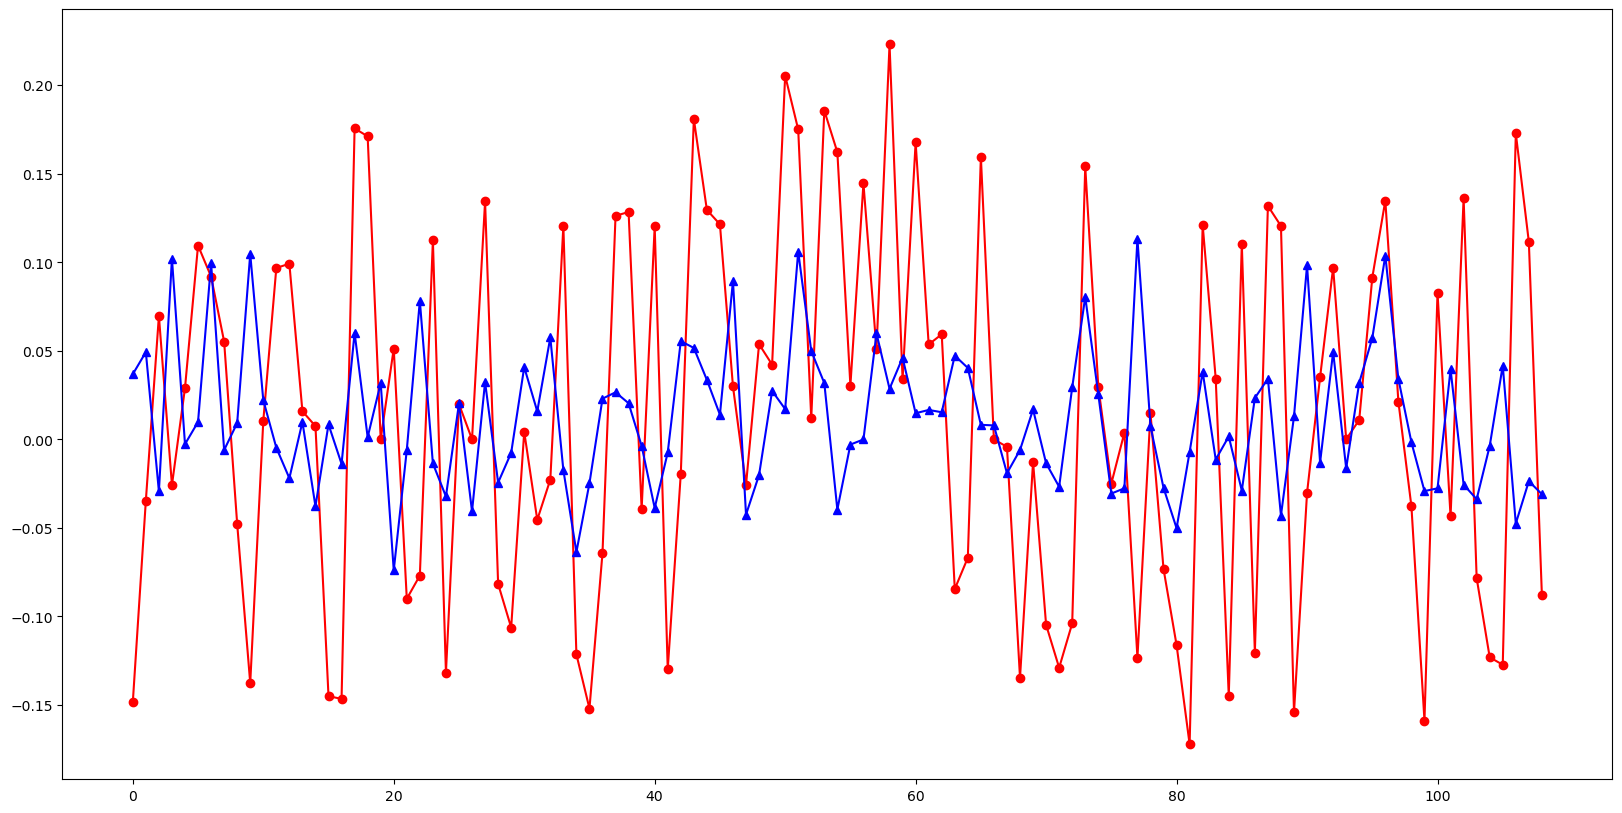

1.3562954287604492

In [34]:
plt.figure(figsize=(20,10))
plt.plot(espacio[:conjunto_train.shape[0]-1] ,objetivo_train[:conjunto_train.shape[0]-1], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:conjunto_train.shape[0]-1],(y_[1:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_train[:conjunto_train.shape[0]-1] - y_[1:])**2)/(len(objetivo_train)-1)

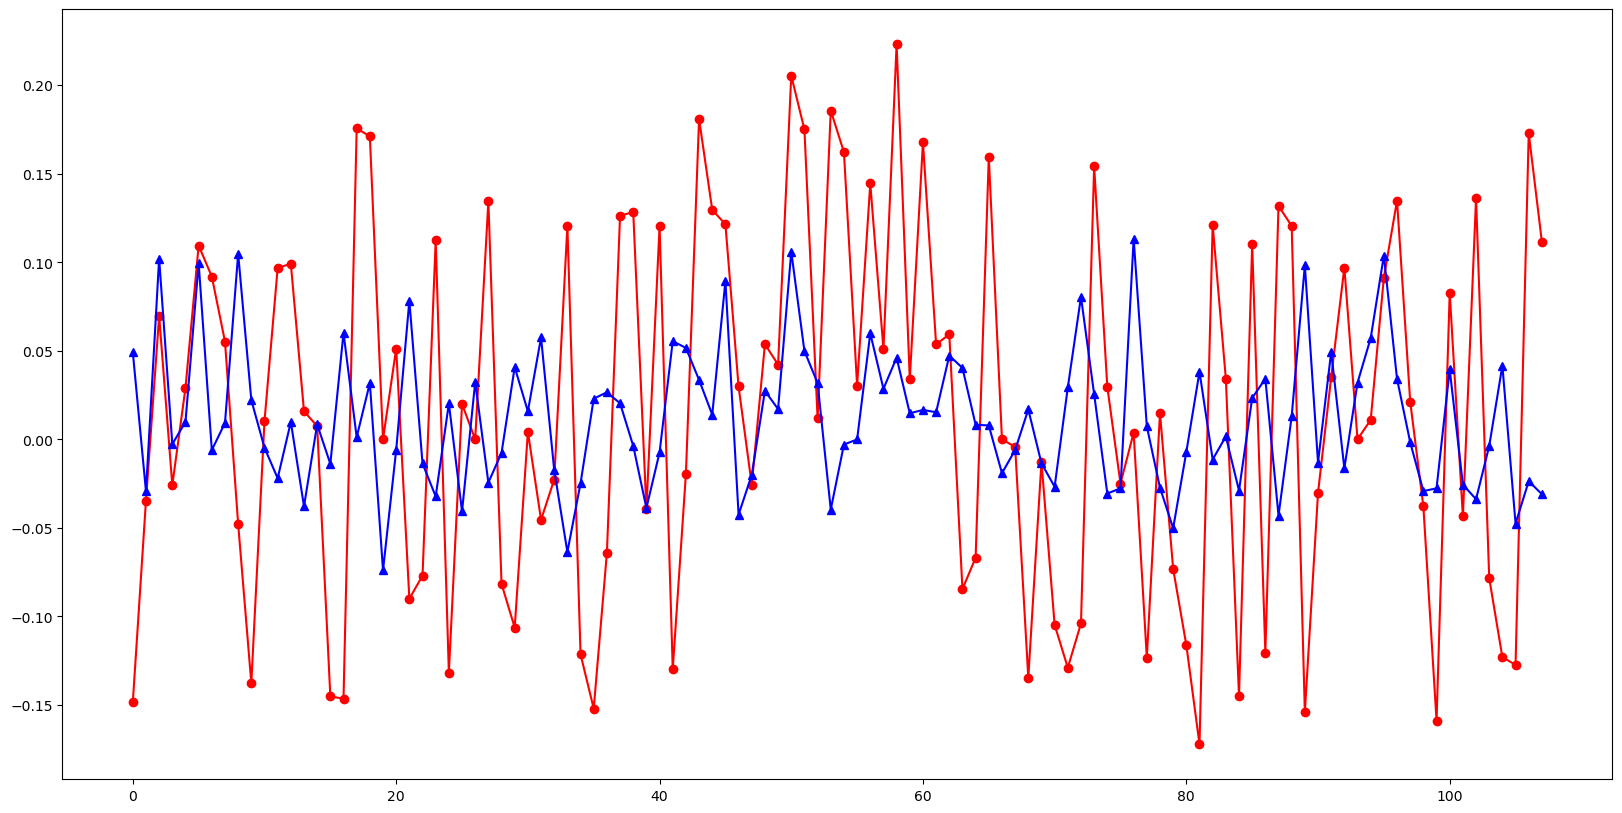

1.3457654886612358

In [35]:
plt.figure(figsize=(20,10))
plt.plot(espacio[:conjunto_train.shape[0]-2] ,objetivo_train[:conjunto_train.shape[0]-2], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[:conjunto_train.shape[0]-2],(y_[2:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_train[:conjunto_train.shape[0]-2] - y_[2:])**2)/(len(objetivo_train)-2)

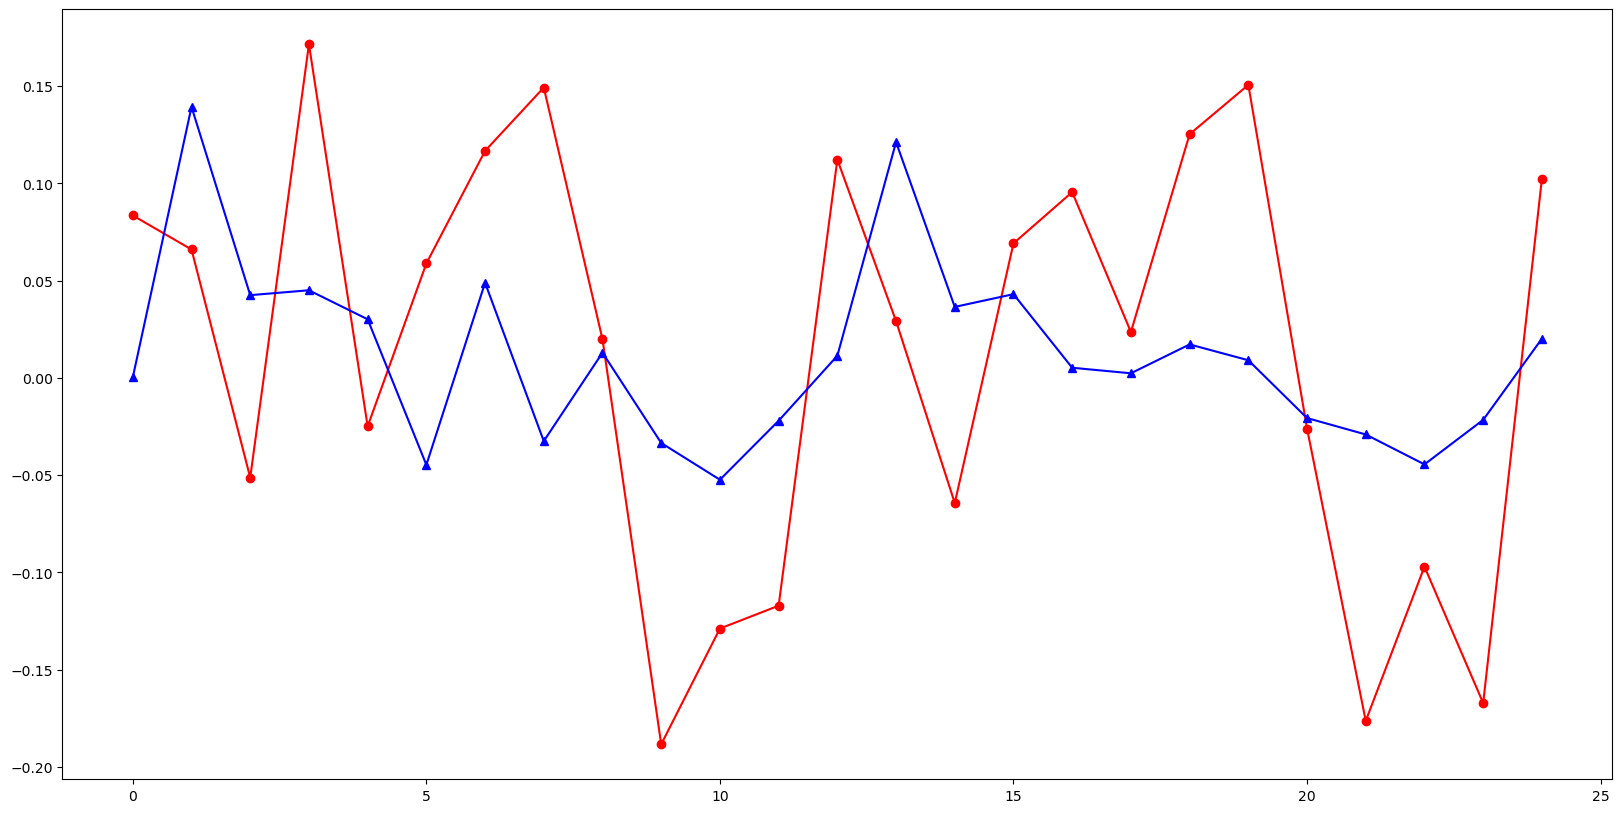

0.3488844487947212

In [36]:
plt.figure(figsize=(20,10))
espacio = np.arange(0,conjunto_test.shape[0])
y_ = vqr.predict(conjunto_test)
plt.plot(espacio ,objetivo_test, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,(y_) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test - y_)**2)/len(objetivo_test)

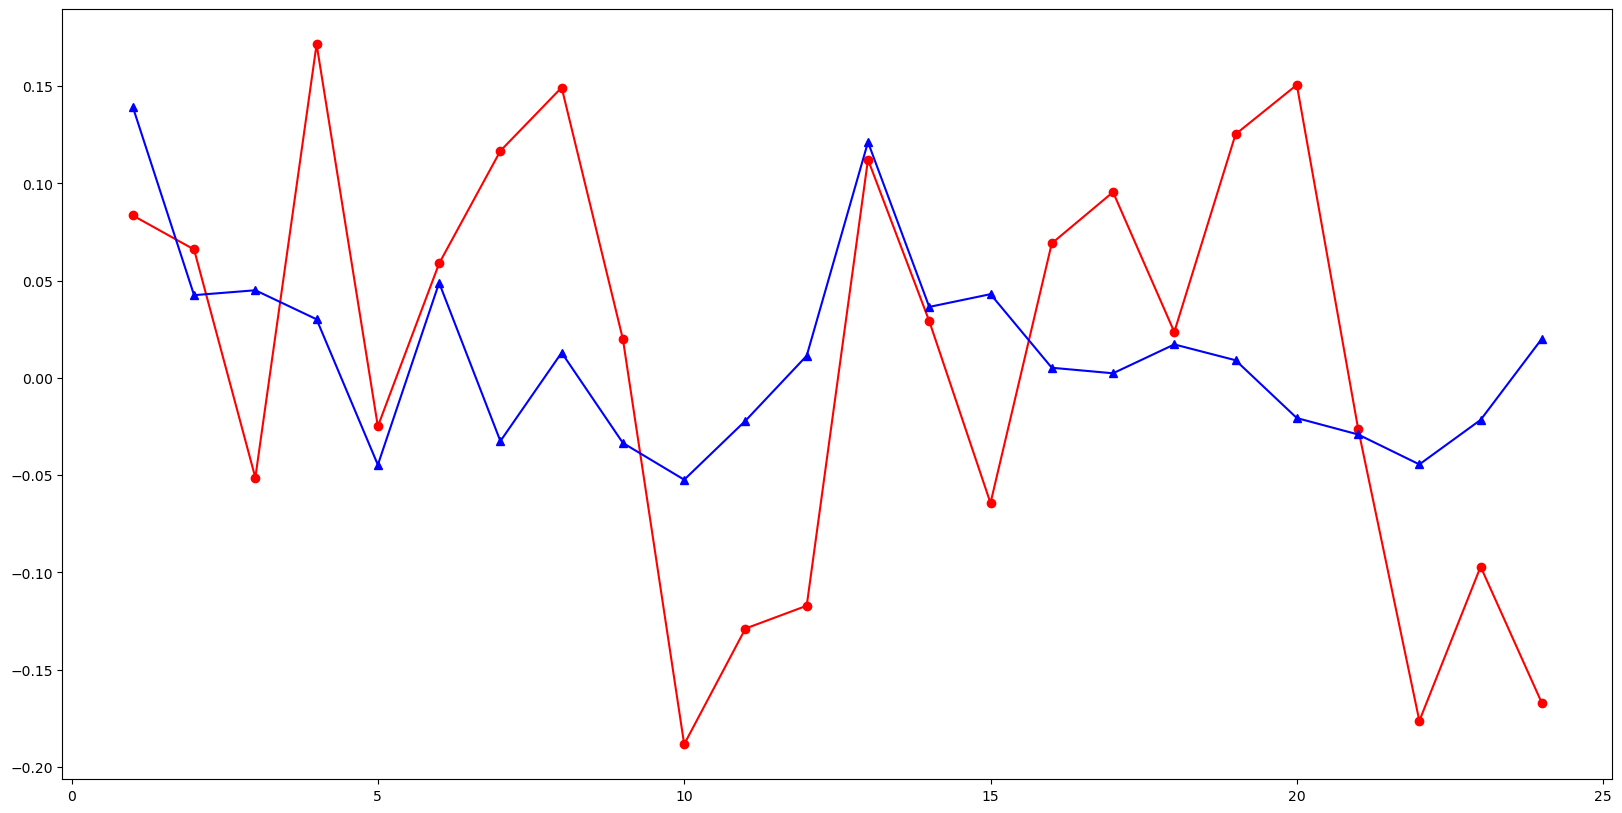

0.35093950244246935

In [37]:
plt.figure(figsize=(20,10))
plt.plot(espacio[1:] ,objetivo_test[:len(espacio)-1], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[1:],(y_[1:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test[:len(espacio-1)] - y_[1:])**2)/(len(objetivo_test)-1)

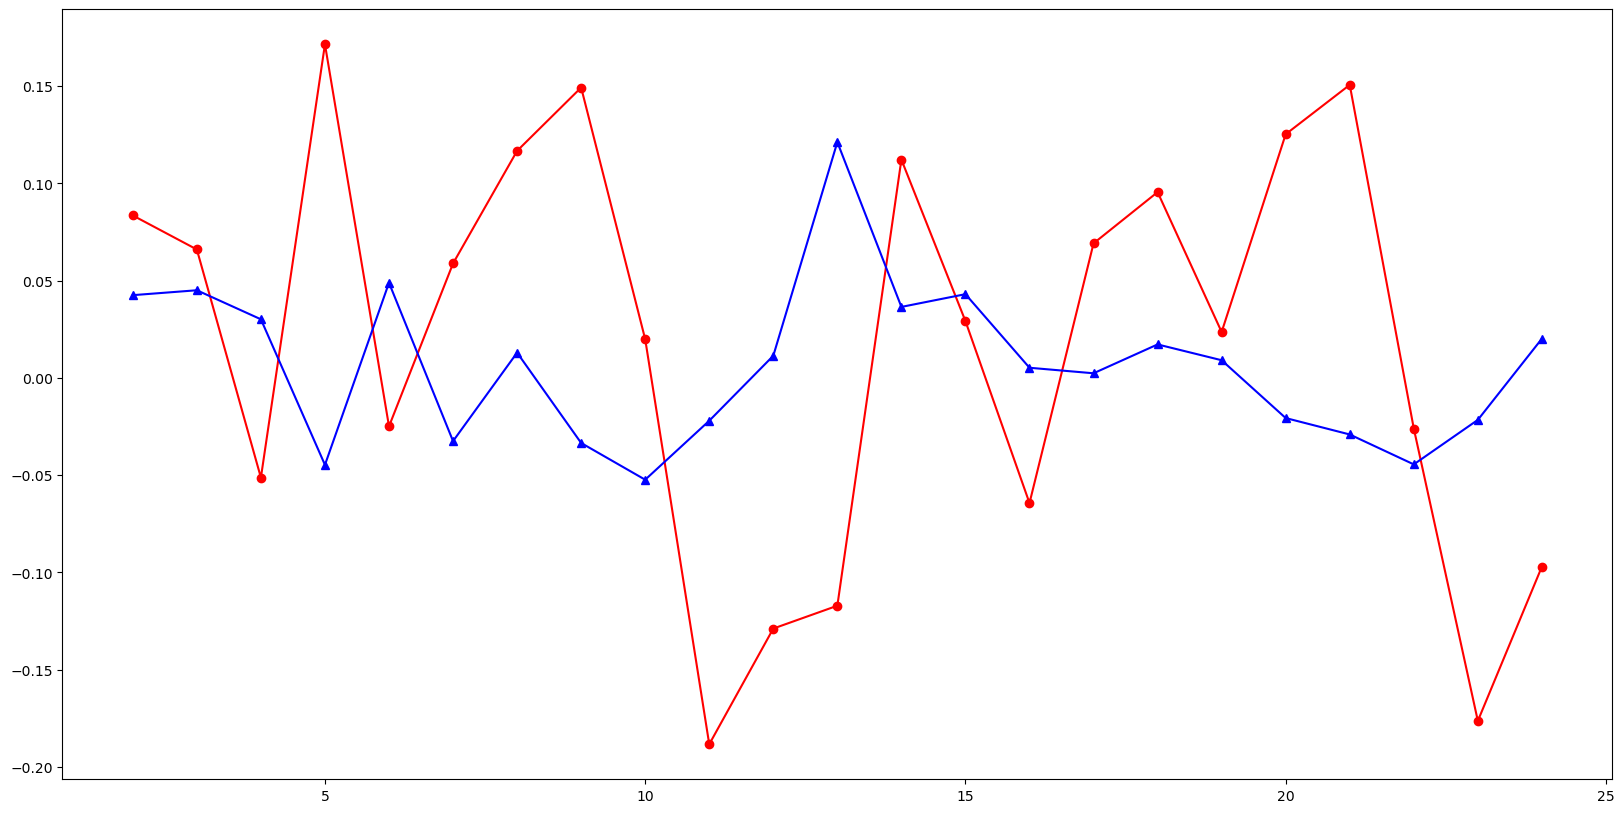

0.33607961341488723

In [38]:
plt.figure(figsize=(20,10))
plt.plot(espacio[2:] ,objetivo_test[:len(espacio)-2], marker='o',color='red', label='Verdaderos')
plt.plot(espacio[2:],(y_[2:]) , color='blue', marker='^', label='Predicciones') 
plt.show()
np.sum( (objetivo_test[:len(espacio-2)] - y_[2:])**2)/(len(objetivo_test)-2)